## **Toxic Comments Classification**

### Part 5 - Fine-Tuning DistilBERT

BERT stands for Bidirectional Encoder Representations from Transformers. It uses a Transformer model to learn contextual relationships between words in a piece of text. Transformers include an encoder to read the input text and a decoder to generate a prediction, but BERT only makes use of the encoder as the goal is to generate a language model.

A transformer model takes in an entire sequence of text all at once instead of reading it in a sequential manner from left to right. In additional, the bidirectional characteristic allows the model to look both back and forward in a piece of text to better understand the context of a particular word. This means that a pre-trained BERT model can be fine-tuned with just one additional layer to create a state-of-the-art model for a wide range of NLP tasks.

DistilBERT is a small, fast, cheap and light Transformer model trained by distilling the BERT base. It has 40% less parameters, runs 60% faster while preserving over 95% of BERT’s performances as measured on the GLUE language understanding benchmark.

In [1]:
# general data wrangling etc
# import math
import numpy as np
import pandas as pd
import time

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

# # general text pre & postprocessing
# import nltk
# from nltk.tokenize import RegexpTokenizer
# import re

# modelling
from sklearn import metrics as smetrics, model_selection
from sklearn.utils import class_weight
import tensorflow as tf
from tensorflow.keras import backend as K, callbacks, initializers, layers, losses, metrics as kmetrics, models, \
    optimizers, preprocessing
import transformers

In [2]:
# load the data
train = pd.read_csv('../input/jigsaw-toxic-comment-classification-challenge/train.csv.zip')
test = pd.read_csv('../input/jigsaw-toxic-comment-classification-challenge/test.csv.zip')

test_labels = pd.read_csv('../input/jigsaw-toxic-comment-classification-challenge/test_labels.csv.zip')
test_labels.drop('id', inplace=True, axis=1)

test = pd.concat([test, test_labels], axis=1)
# remove any unlabelled data
test = test.loc[test.toxic != -1, ]

# convert to a binary classification problem
for df in [train, test]:
    int_cols = df.columns[2:]
    df['toxic_sum'] = df[int_cols].sum(axis=1)
    df['is_toxic'] = df.apply(lambda x: 1 if x['toxic_sum'] > 0 else 0, axis=1)
    
    df.drop('toxic_sum', axis=1, inplace=True)
    
# check the target class balance
train.is_toxic.value_counts(normalize=True)

0    0.898321
1    0.101679
Name: is_toxic, dtype: float64

In [3]:
# rebalance the dataset
clean_texts = train[train.is_toxic == 0]
train_texts = train[train.is_toxic == 1]

# randomly sample from the majority class until it makes up only 80% of the dataset
to_conserve = clean_texts.sample(frac=0.42)
train_rs = to_conserve.append(train_texts, ignore_index=True)
# re-check the balance
train_rs.is_toxic.value_counts(normalize=True)

0    0.787714
1    0.212286
Name: is_toxic, dtype: float64

In [4]:
# split the training data into a train and validation set
X_train_rs, X_valid_rs, y_train_rs, y_valid_rs = model_selection.train_test_split(
    train_rs.comment_text,
    train_rs.is_toxic,
    train_size=0.8,
    stratify=train_rs.is_toxic,
    shuffle=True)

In [5]:
# load the tokeniser and model
tokeniser = transformers.DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

In [6]:
start_time = time.time()

# tokenise the training text
tokenised_text = [tokeniser.tokenize(string) for string in X_train_rs]
# identify the maximum text length
max_len = ([len(array) for array in tokenised_text])
max_len = np.max(max_len)
# BERT models can take a maximum of 512 tokens
if max_len <= 512:
    max_length = max_len
else:
    max_length = 512
print('Maximum sentence length: ', max_length)

end_time = time.time()
print('Elapsed time: {:.2f} minutes'.format((end_time-start_time)/60))

Maximum sentence length:  512
Elapsed time: 1.83 minutes


Like most large language models, DistilBERT likes input in a specific format. A BERT model needs the following tokens:

1. [CLS] or Classification. It represents sentence-level classification and is added to the beginning of each sentence.
2. [SEP]. Added at the end of each sentence.
3. [PAD] or Padding. Used to ensure each sentence is the same length.

For example:
[CLS] Sentence A with [PAD] [SEP] [CLS] Sentence B with [PAD] [SEP]

In [7]:
# define a function to pre-process the text
def preprocess_text(text, max_length):
    # convert the text into an array of encoded sequences
    processed_text = [tokeniser.encode_plus(
        string,
        add_special_tokens=True, # add [CLS] and [SEP]
        max_length=max_length,   # pad and truncate all strings
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        ) for string in text]

    # create tensors of token indices for each text string
    input_ids = [x['input_ids'] for x in processed_text]
    input_id_tensors = tf.convert_to_tensor(input_ids)
    # repeat for the attention mask
    masks = [x['attention_mask'] for x in processed_text]
    mask_tensors = tf.convert_to_tensor(masks)
    
    return text, tokenised_text, processed_text, input_id_tensors, mask_tensors

# apply function to the training, validation and test data
start_time = time.time()

text, tokenised_text, X_train, train_input_id_tensors, train_mask_tensors = preprocess_text(
    X_train_rs, max_length=max_length)
_, _, _, valid_input_id_tensors, valid_mask_tensors = preprocess_text(X_valid_rs, max_length=max_length)
_, _, _, test_input_id_tensors, test_mask_tensors = preprocess_text(test.comment_text, max_length=max_length)

end_time = time.time()
print('Elapsed time: {:.2f} minutes'.format((end_time-start_time)/60))

print("raw text: ", text.reset_index().iloc[4, ]['comment_text'])
print("-----")
print("tokenised text: ", tokenised_text[4])
print("-----")
print("token ids: ", X_train[4]['input_ids'])
print("-----")
print("decoded token ids: ", tokeniser.decode(X_train[4]['input_ids']))
print("-----")
print("attention mask: ", X_train[4]['attention_mask'])

Elapsed time: 5.54 minutes
raw text:  "
As I said in the edit comment, the ""locations"" are not observable. See the Bohm interpretation FAQ section where this is explicitly dealt with (and sourced). If you have a problem with it take it to the Bohm interpretation talk page (although you'd be rehashing something that always comes us.  Still the FAQ could be improved...  talk "
-----
tokenised text:  ['"', 'as', 'i', 'said', 'in', 'the', 'edit', 'comment', ',', 'the', '"', '"', 'locations', '"', '"', 'are', 'not', 'ob', '##ser', '##vable', '.', 'see', 'the', 'bo', '##hm', 'interpretation', 'fa', '##q', 'section', 'where', 'this', 'is', 'explicitly', 'dealt', 'with', '(', 'and', 'sourced', ')', '.', 'if', 'you', 'have', 'a', 'problem', 'with', 'it', 'take', 'it', 'to', 'the', 'bo', '##hm', 'interpretation', 'talk', 'page', '(', 'although', 'you', "'", 'd', 'be', 're', '##has', '##hing', 'something', 'that', 'always', 'comes', 'us', '.', 'still', 'the', 'fa', '##q', 'could', 'be', 'improv

In [8]:
print("Train input shape: ", train_input_id_tensors.shape)
print("Train mask shape: ", train_mask_tensors.shape)
print("Train label shape: ", y_train_rs.shape)
print("Valid input shape: ", valid_input_id_tensors.shape)
print("Valid mask shape: ", valid_mask_tensors.shape)
print("Valid label shape: ", y_valid_rs.shape)
print("Test input shape: ", test_input_id_tensors.shape)
print("Test mask shape: ", test_mask_tensors.shape)
print("Test label shape: ", test.is_toxic.values.shape)

Train input shape:  (61144, 512)
Train mask shape:  (61144, 512)
Train label shape:  (61144,)
Valid input shape:  (15286, 512)
Valid mask shape:  (15286, 512)
Valid label shape:  (15286,)
Test input shape:  (63978, 512)
Test mask shape:  (63978, 512)
Test label shape:  (63978,)


In [9]:
# deine the evaluation metrics
METRICS = [
    kmetrics.AUC(name='prc', curve='PR'),
    kmetrics.AUC(name='auc'),
    kmetrics.BinaryAccuracy(name='accuracy')
]

# # fix the bias (optional)
# classes, counts = np.unique(y_train_rs, return_counts=True)
# initial_bias = np.log([counts[1]/counts[0]])
# output_bias = initializers.Constant(initial_bias)

# calculate balanced class weights
# classes, counts = np.unique(y_train_rs, return_counts=True)
# total = counts[0] + counts[1]
# weight_for_0 = (1 / counts[0]) * (total / 2.0)
# weight_for_1 = (1 / counts[1]) * (total / 2.0)
# balanced_weights_dict = {0: weight_for_0, 1: weight_for_1}
# balanced_weights_dict

# alternative
class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                  classes=np.unique(y_train_rs),
                                                  y=y_train_rs)

# # convert class weights to a dictionary
balanced_weights_dict = dict(enumerate(class_weights))
print('Balanced weights:', balanced_weights_dict)

# calculate inverse frequency weights
total = len(y_train_rs)
unique, counts = np.unique(y_train_rs, return_counts=True)
freqs = counts / total
inv_freqs = 1 / freqs
inv_freqs = inv_freqs / np.sum(inv_freqs)

# combine the class weights with the inverse frequency weights
inverse_weights = np.array(list(balanced_weights_dict.values())) * inv_freqs
inverse_weights_dict = dict(zip(np.unique(y_train_rs), inverse_weights))
print('Inverse weights:', inverse_weights_dict)

Balanced weights: {0: 0.6347479445228802, 1: 2.355315870570108}
Inverse weights: {0: 0.13474794452288016, 1: 1.855315870570108}


A focal loss function is designed to address the problem of class imbalance in binary classification tasks. In class-imbalanced problems, the model may become overly biased towards the majority class and perform poorly on the minority class. This is a common problem in many real-world scenarios where positive cases are rare.

The focal loss function is a modification of the standard cross-entropy loss that down-weights the loss assigned to well-classified ('easy') examples, while putting more emphasis on misclassified ('hard') examples.

In [10]:
# initialise the base model
DROPOUT = 0.2
ATT_DROPOUT = 0.2

# configure DistilBERT's initialisation
config = transformers.DistilBertConfig(dropout=DROPOUT,
                                       attention_dropout=ATT_DROPOUT,
                                       output_hidden_states=True,
                                       num_labels=2)

transformer_model = transformers.TFDistilBertModel.from_pretrained('distilbert-base-uncased', config=config)
# note that we could have chosen a classification-specific model: TFDistilBertForSequenceClassification.
# this adds a task-specific head

# make the distilBERT layers untrainable
for layer in transformer_model.layers:
    layer.trainable=False

# define some more parameters
MAX_LENGTH = max_length
LAYER_DROPOUT = 0.2
LEARNING_RATE = 2e-2 # 2e-5

# define the input layers
input_ids = layers.Input(shape=(MAX_LENGTH,), name='input_ids', dtype='int32')
input_masks = layers.Input(shape=(MAX_LENGTH,), name='attention_mask', dtype='int32')

# DistilBERT outputs a tuple where the first element at index 0
# represents the hidden-state at the output of the model's last layer.
# It is a tf.Tensor of shape (batch_size, sequence_length, hidden_size=768).
transformer_layer = transformer_model([input_ids, input_masks])[0]

# We only care about DistilBERT's output for the [CLS] token, which is located at index 0 of every encoded sequence.  
# Splicing out the [CLS] tokens gives us 2D data.
# don't need this layer if using a max-pooling layer
cls_token = transformer_layer[:, 0, :]

# define additional layers here
# X = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))(transformer_layer)
# X = layers.GlobalMaxPool1D()(X)
X = layers.Dense(64, activation='relu')(cls_token)
X = layers.Dropout(LAYER_DROPOUT)(X)
X = layers.Dense(32, activation='relu')(X)
X = layers.Dropout(LAYER_DROPOUT)(X)

# define a single node making up the output layer
output = layers.Dense(1, activation='sigmoid')(X)
# output = layers.Dense(1, activation='sigmoid', bias_initializer=output_bias)(X)

# define the model
model = models.Model([input_ids, input_masks], output)

# compile the model
model.compile(optimizer=optimizers.Adam(lr=LEARNING_RATE), metrics=METRICS, loss='binary_focal_crossentropy')

model.summary()

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['activation_13', 'vocab_transform', 'vocab_layer_norm', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 512)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 512)]        0           []                               
                                                                                                  
 tf_distil_bert_model (TFDistil  TFBaseModelOutput(l  66362880   ['input_ids[0][0]',              
 BertModel)                     ast_hidden_state=(N               'attention_mask[0][0]']         
                                one, 512, 768),                                                   
                                 hidden_states=((No                                           

In [11]:
# # add a callback
# es = callbacks.EarlyStopping(monitor='val_prc', mode='max', verbose=1, patience=5)

# fit the model to the training data
start_time = time.time()

history = model.fit([train_input_id_tensors, train_mask_tensors], y_train_rs, batch_size=64, epochs=5,
                    validation_data=([valid_input_id_tensors, valid_mask_tensors], y_valid_rs),
                    verbose=1, class_weight=balanced_weights_dict)

end_time = time.time()
print('Elapsed time: {:.2f} minutes'.format((end_time-start_time)/60))

Epoch 1/5
956/956 [==============================] - 903s 936ms/step - loss: 0.0872 - prc: 0.8244 - auc: 0.9324 - accuracy: 0.8553 - val_loss: 0.0622 - val_prc: 0.8917 - val_auc: 0.9593 - val_accuracy: 0.9127
Epoch 2/5
956/956 [==============================] - 893s 934ms/step - loss: 0.0770 - prc: 0.8634 - auc: 0.9482 - accuracy: 0.8741 - val_loss: 0.0552 - val_prc: 0.8937 - val_auc: 0.9599 - val_accuracy: 0.9153
Epoch 3/5
956/956 [==============================] - 844s 883ms/step - loss: 0.0747 - prc: 0.8691 - auc: 0.9510 - accuracy: 0.8754 - val_loss: 0.0606 - val_prc: 0.8960 - val_auc: 0.9613 - val_accuracy: 0.9060
Epoch 4/5
956/956 [==============================] - 844s 883ms/step - loss: 0.0744 - prc: 0.8716 - auc: 0.9516 - accuracy: 0.8785 - val_loss: 0.0589 - val_prc: 0.8975 - val_auc: 0.9617 - val_accuracy: 0.9087
Epoch 5/5
956/956 [==============================] - 893s 934ms/step - loss: 0.0734 - prc: 0.8741 - auc: 0.9530 - accuracy: 0.8785 - val_loss: 0.0619 - val_prc: 0.8

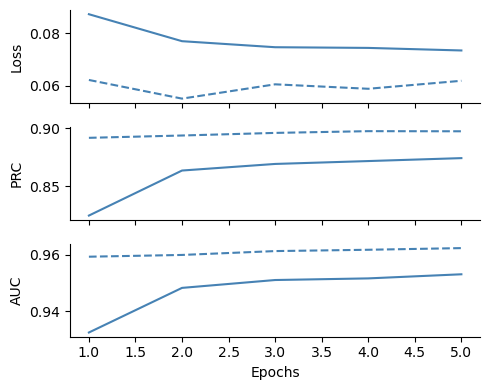

In [12]:
metrics = [k for k in history.history.keys() if ("loss" not in k) and ("val" not in k)]

fig, ax = plt.subplots(figsize=(5, 4), nrows=3, ncols=1, sharex=True)
# plot loss
sns.lineplot(x=[i+1 for i in range(len(history.history['loss']))], y=history.history['loss'], ax=ax[0],
             color='steelblue')
sns.lineplot(x=[i+1 for i in range(len(history.history['val_loss']))], y=history.history['val_loss'],
             ax=ax[0], color='steelblue', linestyle='dashed')
ax[0].set(xlabel="Epochs", ylabel="Loss")

# plot PRC
sns.lineplot(x=[i+1 for i in range(len(history.history['prc']))], y=history.history['prc'], ax=ax[1],
             color='steelblue')
sns.lineplot(x=[i+1 for i in range(len(history.history['val_prc']))], y=history.history['val_prc'],
             ax=ax[1], color='steelblue', linestyle='dashed')
ax[1].set(xlabel="Epochs", ylabel="PRC")

# plot AUC
sns.lineplot(x=[i+1 for i in range(len(history.history['auc']))], y=history.history['auc'], ax=ax[2],
             color='steelblue')
sns.lineplot(x=[i+1 for i in range(len(history.history['val_auc']))], y=history.history['val_auc'],
             ax=ax[2], color='steelblue', linestyle='dashed')
ax[2].set(xlabel="Epochs", ylabel="AUC")

fig.tight_layout()
sns.despine()

2000/2000 [==============================] - 656s 327ms/step
AUPRC: 0.67
F1 score: 0.5
AUC: 0.93
Accuracy: 0.83
Detail:
              precision    recall  f1-score   support

           0       0.98      0.83      0.90     57735
           1       0.35      0.88      0.50      6243

    accuracy                           0.83     63978
   macro avg       0.67      0.85      0.70     63978
weighted avg       0.92      0.83      0.86     63978



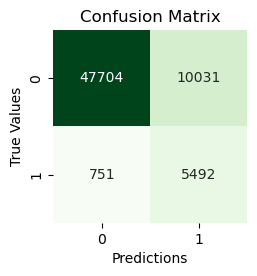

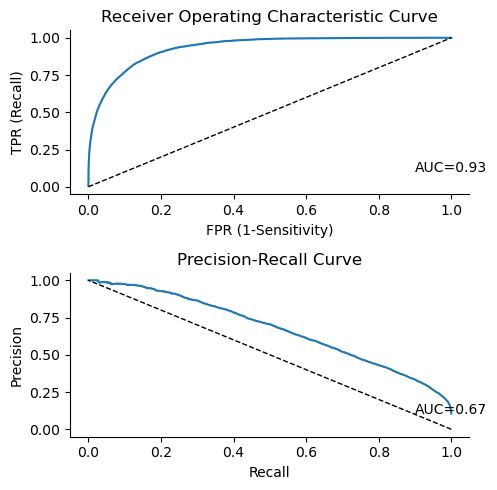

In [13]:
# make predictions on the test set
pred_probs = model.predict([test_input_id_tensors, test_mask_tensors])
preds = (pred_probs > 0.5).astype(int)
y_test = test.is_toxic.values

# evaluate model performance
auc = smetrics.roc_auc_score(y_test, pred_probs)
f1 = smetrics.f1_score(y_test, preds)
auprc = smetrics.average_precision_score(y_test, pred_probs)
accuracy = smetrics.accuracy_score(y_test, preds)

print("AUPRC:", round(auprc, 2))
print("F1 score:", round(f1, 2))
print("AUC:", round(auc, 2))
print("Accuracy:", round(accuracy, 2))
print("Detail:")
print(smetrics.classification_report(y_test, preds))

cm = smetrics.confusion_matrix(y_test, preds)
fig, ax = plt.subplots(figsize=(2.5, 2.5))
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Greens, cbar=False)
plt.xlabel("Predictions")
plt.ylabel("True Values")
plt.title("Confusion Matrix")

fig, ax = plt.subplots(figsize=(5, 5), nrows=2, ncols=1)
# plot precision-recall curve
precision, recall, thresholds = smetrics.precision_recall_curve(y_test, pred_probs)
sns.lineplot(x=recall, y=precision, ax=ax[1])
ax[1].text(x=0.9, y=0.1, s='AUC={0:0.2f}'.format(auprc))
ax[1].plot([1,0], [0,1], color='black', linestyle='--', lw=1)
ax[1].set(xlabel="Recall",
          ylabel="Precision",
          title="Precision-Recall Curve")

# plot roc curve
fpr, tpr, thresholds = smetrics.roc_curve(y_test, pred_probs)
sns.lineplot(x=fpr, y=tpr, ax=ax[0])
ax[0].text(x=0.9, y=0.1, s='AUC={0:0.2f}'.format(auc))
ax[0].plot([0,1], [0,1], color='black', linestyle='--', lw=1)
ax[0].set(xlabel="FPR (1-Sensitivity)",
          ylabel="TPR (Recall)",
          title="Receiver Operating Characteristic Curve")

fig.tight_layout()
sns.despine()

The performance is again ok, but not great.

In [60]:
# check some of the miss-classified comments
missclassified_comments = pd.DataFrame(data={'preds':preds.flatten(), 'actuals':y_test, 'text': test.comment_text})
missclassified_comments = missclassified_comments[missclassified_comments.preds != missclassified_comments.actuals]

# pick a random comment and take a look
comment = missclassified_comments.sample(10)

for i in range(len(comment)):
    print(i)
    print('Predicted label:', comment.preds.iloc[i], '; Actual label', comment.actuals.iloc[i])
    print(comment.text.iloc[i])
    print('-----')

0
Predicted label: 1 ; Actual label 0
:Razumem brate, ipak hvala na trudu. Ja isto pokusavam sve sto mogu. Ja dosta radim oko clanaka, ali bavi cu se i sa slikama, da nabavim itd. pozz brate.4C
-----
1
Predicted label: 1 ; Actual label 0
Rugaminte 
 Am vazut ca ai contribuit la articolul Moldovan language. Sunt complicate lucrile pe acolo. 

 Eu am o rugaminte. Ai putea sa iti faci un cont cand contribuii acolo? Asta ar ajuta foarte mult in colaborare, si ar fi mai clar ce se intampla. Multam,
-----
2
Predicted label: 1 ; Actual label 0
" 

 == More hate inciting by Darknesshines ==  
 How am I supposed to keep mum on this obvious bigoted pov push by DS?  are pakistani editors just supposed to ""live"" with it other users have also picked up on his trolling and you expect me not to react to his bullshit? hes constantly trying to either get a reaction out of me or some pakistani editor by edit warring and creating such contentious articles    
 : You know dam well why hes DYK that stupi